# Clustering

In [3]:
!pip install lifetimes
#!pip install dtale
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from decimal import Decimal
import datetime as dt
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
trx=pd.read_csv('/content/drive/MyDrive/ds final/trx_table.csv')
item=pd.read_csv('/content/drive/MyDrive/ds final/item_info.csv')
trx.head()

,customer_code,transaction_time,item code,sales_quantity
0,customer_code_78,1/3/2023 13:49,item_cd_12,13
1,customer_code_78,1/12/2023 8:08,item_cd_6,14
2,customer_code_78,1/17/2023 12:15,item_cd_2,14
3,customer_code_78,1/25/2023 16:37,item_cd_16,11
4,customer_code_78,2/3/2023 15:11,item_cd_3,14


#Preprocessing

In [6]:
# prompt: split the transaction time by space and change the date to correct dtype

import pandas as pd
#trx['transaction_time'] = trx['transaction_time'].apply(lambda x: x.split(' ')[0])
trx['transaction_time'] = pd.to_datetime(trx['transaction_time'])
# Drop duplicates
trx = trx.drop_duplicates()


# Outlier removal
threshold = 3
for col in ['sales_quantity']:
    mean = trx[col].mean()
    std_dev = trx[col].std()
    trx = trx[(trx[col] >= mean - threshold * std_dev) & (trx[col] <= mean + threshold * std_dev)]
trx.head()

,customer_code,transaction_time,item code,sales_quantity
0,customer_code_78,2023-01-03 13:49:00,item_cd_12,13
1,customer_code_78,2023-01-12 08:08:00,item_cd_6,14
2,customer_code_78,2023-01-17 12:15:00,item_cd_2,14
3,customer_code_78,2023-01-25 16:37:00,item_cd_16,11
4,customer_code_78,2023-02-03 15:11:00,item_cd_3,14


In [7]:
# Encode item_code
label_encoder = LabelEncoder()
trx['item_code_encoded'] = label_encoder.fit_transform(trx['item code'])
data = pd.merge(trx, item, on='item code', how='left')
data.head()

,customer_code,transaction_time,item code,sales_quantity,item_code_encoded,department,item_category,item_name
0,customer_code_78,2023-01-03 13:49:00,item_cd_12,13,3,fresh,fruits,green apple
1,customer_code_78,2023-01-12 08:08:00,item_cd_6,14,55,fresh,vegetables,beetroot
2,customer_code_78,2023-01-17 12:15:00,item_cd_2,14,11,fresh,vegetables,potatoes
3,customer_code_78,2023-01-25 16:37:00,item_cd_16,11,7,fresh,fruits,mango
4,customer_code_78,2023-02-03 15:11:00,item_cd_3,14,22,fresh,vegetables,pumpkin


In [8]:
# Calculate the current date from the dataset
df=data.copy()
current_date = df['transaction_time'].max()# Group by item code to calculate the metrics
item_metrics = df.groupby('item code').agg({
    'sales_quantity': ['sum', 'mean', 'count'],  # Total sales, Average sales, Number of transactions
    'customer_code': 'nunique',  # Number of unique customers
    'transaction_time': lambda x: (current_date - x.max()).days  # Recency of last sale
})

# Rename columns for better readability
item_metrics.columns = ['total_sales_quantity', 'average_sales_quantity', 'transaction_count', 'unique_customers', 'recency_of_last_sale']
item_metrics.reset_index(inplace=True)

item_metrics

,item code,total_sales_quantity,average_sales_quantity,transaction_count,unique_customers,recency_of_last_sale
0,item_cd_1,76764,6.424841,11948,1761,0
1,item_cd_10,137889,5.584585,24691,4200,0
2,item_cd_11,137651,6.704871,20530,4200,0
3,item_cd_12,77572,6.472424,11985,1760,0
4,item_cd_13,112263,6.849064,16391,4200,0
...,...,...,...,...,...,...
65,item_cd_69,68465,5.089578,13452,4200,0
66,item_cd_7,124784,6.051307,20621,4200,0
67,item_cd_70,77284,5.729409,13489,4200,0
68,item_cd_8,78670,6.556380,11999,1762,0


In [9]:
item_metrics.describe()

,total_sales_quantity,average_sales_quantity,transaction_count,unique_customers,recency_of_last_sale
count,70.000000,70.000000,70.000000,70.000000,70.0
mean,59249.514286,6.627863,9144.542857,2009.157143,0.0
std,40564.508872,1.866162,6652.210237,1855.267430,0.0
min,9786.000000,3.470145,1773.000000,168.000000,0.0
25%,31392.000000,5.696313,4098.500000,252.000000,0.0
50%,53003.500000,6.483004,7185.000000,1320.000000,0.0
75%,78664.250000,7.650924,13090.250000,4200.000000,0.0
max,206806.000000,10.150046,30176.000000,4200.000000,0.0


In [10]:

# Calculate the current date from the dataset
current_date = df['transaction_time'].max()

# Calculate Customer-Level Metrics
customer_metrics = df.groupby('customer_code').agg({
    'transaction_time': [
        lambda x: (current_date - x.max()).days,  # Recency
        lambda x: (current_date - x.min()).days,  # Tenure
        'count'  # Frequency
    ],
    'sales_quantity': 'sum'  # Monetary value
})

# Rename columns for better readability
customer_metrics.columns = ['recency', 'tenure', 'frequency', 'total_sales']
customer_metrics.reset_index(inplace=True)

# Calculate Item-Related Metrics for Each Customer

# Total unique items purchased
unique_items = df.groupby('customer_code')['item code'].nunique().reset_index()
unique_items.columns = ['customer_code', 'unique_items_purchased']

# Most frequently purchased item and total quantity of the most frequently purchased item
most_frequent_item = df.groupby(['customer_code', 'item code']).agg({
    'sales_quantity': 'sum'
}).reset_index().sort_values(by=['customer_code', 'sales_quantity'], ascending=[True, False])

most_frequent_item = most_frequent_item.groupby('customer_code').first().reset_index()
most_frequent_item.columns = ['customer_code', 'most_frequent_item', 'most_frequent_item_quantity']

# Average quantity per item
avg_quantity_per_item = df.groupby('customer_code').agg({
    'sales_quantity': 'mean'
}).reset_index()
avg_quantity_per_item.columns = ['customer_code', 'average_quantity_per_item']

# Merge customer metrics with item-related metrics
customer_metrics = customer_metrics.merge(unique_items, on='customer_code', how='left')
customer_metrics = customer_metrics.merge(most_frequent_item, on='customer_code', how='left')
customer_metrics = customer_metrics.merge(avg_quantity_per_item, on='customer_code', how='left')

# Display the result
(customer_metrics)

,customer_code,recency,tenure,frequency,total_sales,unique_items_purchased,most_frequent_item,most_frequent_item_quantity,average_quantity_per_item
0,customer_code_1,0,187,152,1081,35,item_cd_10,108,7.111842
1,customer_code_10,1,187,156,1509,31,item_cd_68,277,9.673077
2,customer_code_100,1,187,148,1354,31,item_cd_26,200,9.148649
3,customer_code_1000,0,187,153,475,35,item_cd_11,43,3.104575
4,customer_code_1001,0,187,153,483,35,item_cd_6,51,3.156863
...,...,...,...,...,...,...,...,...,...
4195,customer_code_995,0,187,150,1241,31,item_cd_31,188,8.273333
4196,customer_code_996,0,187,149,1322,31,item_cd_31,211,8.872483
4197,customer_code_997,1,187,168,1450,35,item_cd_15,115,8.630952
4198,customer_code_998,0,187,167,1463,35,item_cd_5,140,8.760479


In [11]:
# Create pivot table for count with suffix '_count'
pivot_count = trx.pivot_table(index='customer_code', columns='item code', values='transaction_time',
                              aggfunc=lambda x: len(x), fill_value=0, margins=False)
pivot_count.columns = [f'{col}_count' for col in pivot_count.columns]

# Create pivot table for sum with suffix '_sales'
pivot_sum = trx.pivot_table(index='customer_code', columns='item code', values='sales_quantity',
                            aggfunc='sum', fill_value=0, margins=False)
pivot_sum.columns = [f'{col}_sales' for col in pivot_sum.columns]

# Merge pivot tables horizontally
merged_pivot = pd.concat([pivot_count, pivot_sum], axis=1)

# Rearrange columns by sorting based on item code numbers
merged_pivot = merged_pivot.reindex(sorted(merged_pivot.columns), axis=1)

# Reset index to make 'customer_code' a column again (optional, depending on your preference)
merged_pivot = merged_pivot.reset_index()

# Display the rearranged pivot table
(merged_pivot)

,customer_code,item_cd_10_count,item_cd_10_sales,item_cd_11_count,item_cd_11_sales,item_cd_12_count,item_cd_12_sales,item_cd_13_count,item_cd_13_sales,item_cd_14_count,...,item_cd_6_count,item_cd_6_sales,item_cd_70_count,item_cd_70_sales,item_cd_7_count,item_cd_7_sales,item_cd_8_count,item_cd_8_sales,item_cd_9_count,item_cd_9_sales
0,customer_code_1,11,108,11,97,3,18,6,27,4,...,13,93,1,4,10,99,2,26,9,65
1,customer_code_10,3,14,2,14,0,0,1,8,1,...,3,15,8,126,2,11,0,0,1,6
2,customer_code_100,3,14,2,14,0,0,1,8,1,...,3,15,1,4,2,11,0,0,1,6
3,customer_code_1000,9,25,14,43,7,19,7,20,5,...,13,38,1,4,4,15,3,6,7,23
4,customer_code_1001,13,41,7,21,8,17,7,22,6,...,19,51,1,4,7,25,4,11,5,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,customer_code_995,3,14,2,14,0,0,1,8,1,...,3,15,1,4,2,11,0,0,1,6
4196,customer_code_996,3,14,2,14,0,0,1,8,1,...,3,15,1,4,2,11,0,0,1,6
4197,customer_code_997,13,61,10,99,9,66,11,93,9,...,11,76,1,4,7,76,5,68,11,107
4198,customer_code_998,8,83,8,82,3,27,9,65,9,...,11,86,1,4,11,84,3,28,4,70


#Building model

In [12]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Select numerical columns for PCA
numerical_cols = [col for col in merged_pivot.columns if 'count' in col or 'sales' in col]
X = merged_pivot[numerical_cols]
#X=customer_metrics[['total_sales','frequency','item_name_encoded']]
X=scaler.fit_transform(X)
# Initialize PCA
pca = PCA(0.9)

# Fit PCA
pca.fit(X)

# Transform the data
X_pca = pca.transform(X)




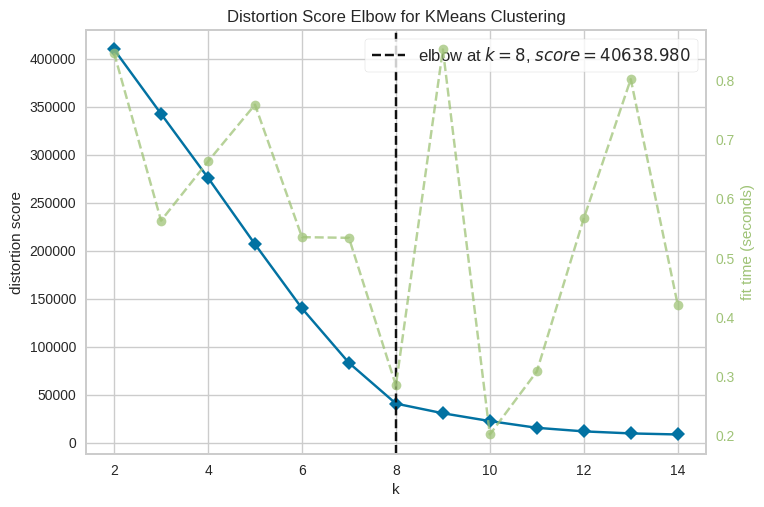

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
from yellowbrick.cluster import KElbowVisualizer


# Instantiate the clustering model and visualizer
km_model = KMeans()
visualizer = KElbowVisualizer(km_model, k=(2,15))

visualizer.fit(X_pca)        # Fit the data to the visualizer
visualizer.show()

In [14]:
optimal_k = visualizer.elbow_value_
optimal_k

8

In [15]:
km_model = KMeans(n_clusters=optimal_k)
km_model.fit(X_pca)
# Creating a new column called cluster whose values are the corresponding cluster for each point.
merged_pivot['cluster'] = km_model.labels_



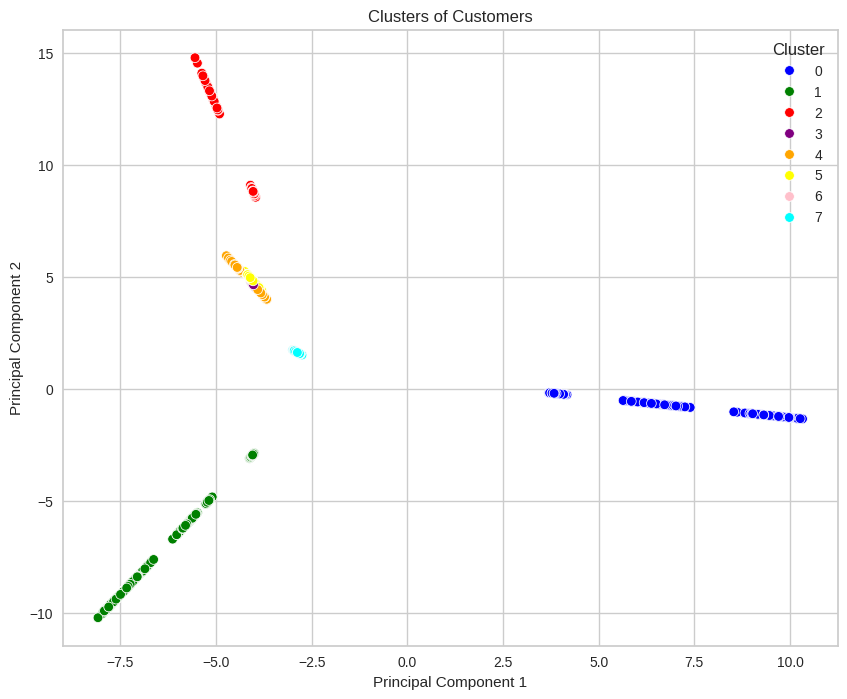

In [16]:
# Further reduce to 2 components for visualization
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_pca)

# Creating a DataFrame with the 2 PCA components and cluster labels
df_pca_2 = pd.DataFrame(X_pca_2, columns=['PCA1', 'PCA2'])
df_pca_2['cluster'] = km_model.labels_

# Define custom colors for clusters
cluster_colors = {
    0: 'blue',
    1: 'green',
    2: 'red',
    3: 'purple',
    4: 'orange',
    5: 'yellow',
    6: 'pink',
    7: 'cyan',
}

# Mapping the custom colors to the clusters
df_pca_2['color'] = df_pca_2['cluster'].map(cluster_colors)

# Plotting the clusters with custom colors
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', palette=cluster_colors, data=df_pca_2, legend='full')
plt.title('Clusters of Customers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

In [18]:
# Define custom colors for clusters (replace with your desired colors)
import plotly.express as px
cluster_colors = {
    0: 'blue',
    1: 'green',
    2: 'red',
    3: 'purple',
    4: 'orange',
    5: 'yellow',
    6: 'pink',
    7: 'cyan',
}

# Create 3D Scatter Plot with custom cluster colors using Plotly
fig = px.scatter_3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 3],
    color=merged_pivot['cluster'].astype(str),  # Convert cluster labels to string for color mapping
    color_discrete_map=cluster_colors,  # Assign custom colors based on cluster number
    title='PCA 3D Visualization with K-means Clustering',
    labels={'x': 'Principal Component 1', 'y': 'Principal Component 2', 'z': 'Principal Component 3'},
    opacity=0.8,
    hover_name=merged_pivot['customer_code']
)

fig.show()

In [19]:
#merged_pivot[['customer_code','cluster']].to_csv('cluster.csv')

In [20]:
cluster_results=merged_pivot[['customer_code','cluster']]

In [21]:
customer_data = customer_metrics.merge(cluster_results, on='customer_code')


In [22]:
total=data.merge(cluster_results,on='customer_code')
total

,customer_code,transaction_time,item code,sales_quantity,item_code_encoded,department,item_category,item_name,cluster
0,customer_code_78,2023-01-03 13:49:00,item_cd_12,13,3,fresh,fruits,green apple,0
1,customer_code_78,2023-01-12 08:08:00,item_cd_6,14,55,fresh,vegetables,beetroot,0
2,customer_code_78,2023-01-17 12:15:00,item_cd_2,14,11,fresh,vegetables,potatoes,0
3,customer_code_78,2023-01-25 16:37:00,item_cd_16,11,7,fresh,fruits,mango,0
4,customer_code_78,2023-02-03 15:11:00,item_cd_3,14,22,fresh,vegetables,pumpkin,0
...,...,...,...,...,...,...,...,...,...
640113,customer_code_3057,2023-02-15 13:41:00,item_cd_11,4,2,fresh,fruits,fuji apple,7
640114,customer_code_3057,2023-07-07 16:54:00,item_cd_63,4,59,animal products,frozen_meat,pork_bacon_500g,7
640115,customer_code_3057,2023-04-17 13:33:00,item_cd_54,8,49,homeware,stationery,glue_stick,7
640116,customer_code_3057,2023-05-30 09:54:00,item_cd_26,10,18,Hygiene,beauty_and_personal_care,conditioner,7


In [23]:
customer_data[['frequency','total_sales','unique_items_purchased','cluster']].groupby('cluster').describe().T

cluster                                 0            1            2  \
frequency              count  1763.000000   882.000000   168.000000   
                       mean    154.800908   149.744898   151.589286   
                       std       5.977214    10.814586     2.280693   
                       min     149.000000   126.000000   144.000000   
                       25%     152.000000   153.000000   150.750000   
                       50%     153.000000   153.000000   153.000000   
                       75%     153.000000   153.000000   153.000000   
                       max     172.000000   180.000000   153.000000   
total_sales            count  1763.000000   882.000000   168.000000   
                       mean    942.418605   911.538549   848.000000   
                       std     330.143782   345.616528   321.894262   
                       min     452.000000   366.000000   578.000000   
                       25%     514.000000   781.000000   608.000000   
                       50%     999.000000   837.000000   621.500000   
                       75%    1067.000000  1307.750000  1250.250000   
                       max    1625.000000  1604.000000  1441.000000   
unique_items_purchased count  1763.000000   882.000000   168.000000   
                       mean     34.989790    31.000000    35.000000   
                       std       0.100555     0.000000     0.000000   
                       min      34.000000    31.000000    35.000000   
                       25%      35.000000    31.000000    35.000000   
                       50%      35.000000    31.000000    35.000000   
                       75%      35.000000    31.000000    35.000000   
                       max      35.000000    31.000000    35.000000   

cluster                                3            4            5  \
frequency              count  252.000000   295.000000   336.000000   
                       mean   153.000000   156.549153   148.800595   
                       std      0.000000     9.838671     2.183821   
                       min    153.000000   149.000000   142.000000   
                       25%    153.000000   151.000000   147.000000   
                       50%    153.000000   152.000000   149.000000   
                       75%    153.000000   153.000000   151.000000   
                       max    153.000000   180.000000   153.000000   
total_sales            count  252.000000   295.000000   336.000000   
                       mean   609.789683  1090.264407  1268.943452   
                       std     12.839160   166.700956    67.695453   
                       min    566.000000   872.000000  1076.000000   
                       25%    602.000000   987.500000  1227.000000   
                       50%    610.000000  1031.000000  1274.500000   
                       75%    618.000000  1087.500000  1312.250000   
                       max    641.000000  1560.000000  1457.000000   
unique_items_purchased count  252.000000   295.000000   336.000000   
                       mean    36.000000    36.000000    31.000000   
                       std      0.000000     0.000000     0.000000   
                       min     36.000000    36.000000    31.000000   
                       25%     36.000000    36.000000    31.000000   
                       50%     36.000000    36.000000    31.000000   
                       75%     36.000000    36.000000    31.000000   
                       max     36.000000    36.000000    31.000000   

cluster                                 6            7  
frequency              count   252.000000   252.000000  
                       mean    148.654762   148.674603  
                       std       2.133927     2.064032  
                       min     142.000000   141.000000  
                       25%     147.000000   147.000000  
                       50%     149.000000   149.000000  
                       75%     150.000000   150.000000  
                 

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640118 entries, 0 to 640117
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   customer_code      640118 non-null  object        
 1   transaction_time   640118 non-null  datetime64[ns]
 2   item code          640118 non-null  object        
 3   sales_quantity     640118 non-null  int64         
 4   item_code_encoded  640118 non-null  int64         
 5   department         640118 non-null  object        
 6   item_category      640118 non-null  object        
 7   item_name          640118 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 39.1+ MB


In [25]:
df_merged = data.merge(cluster_results, on='customer_code', how='left')


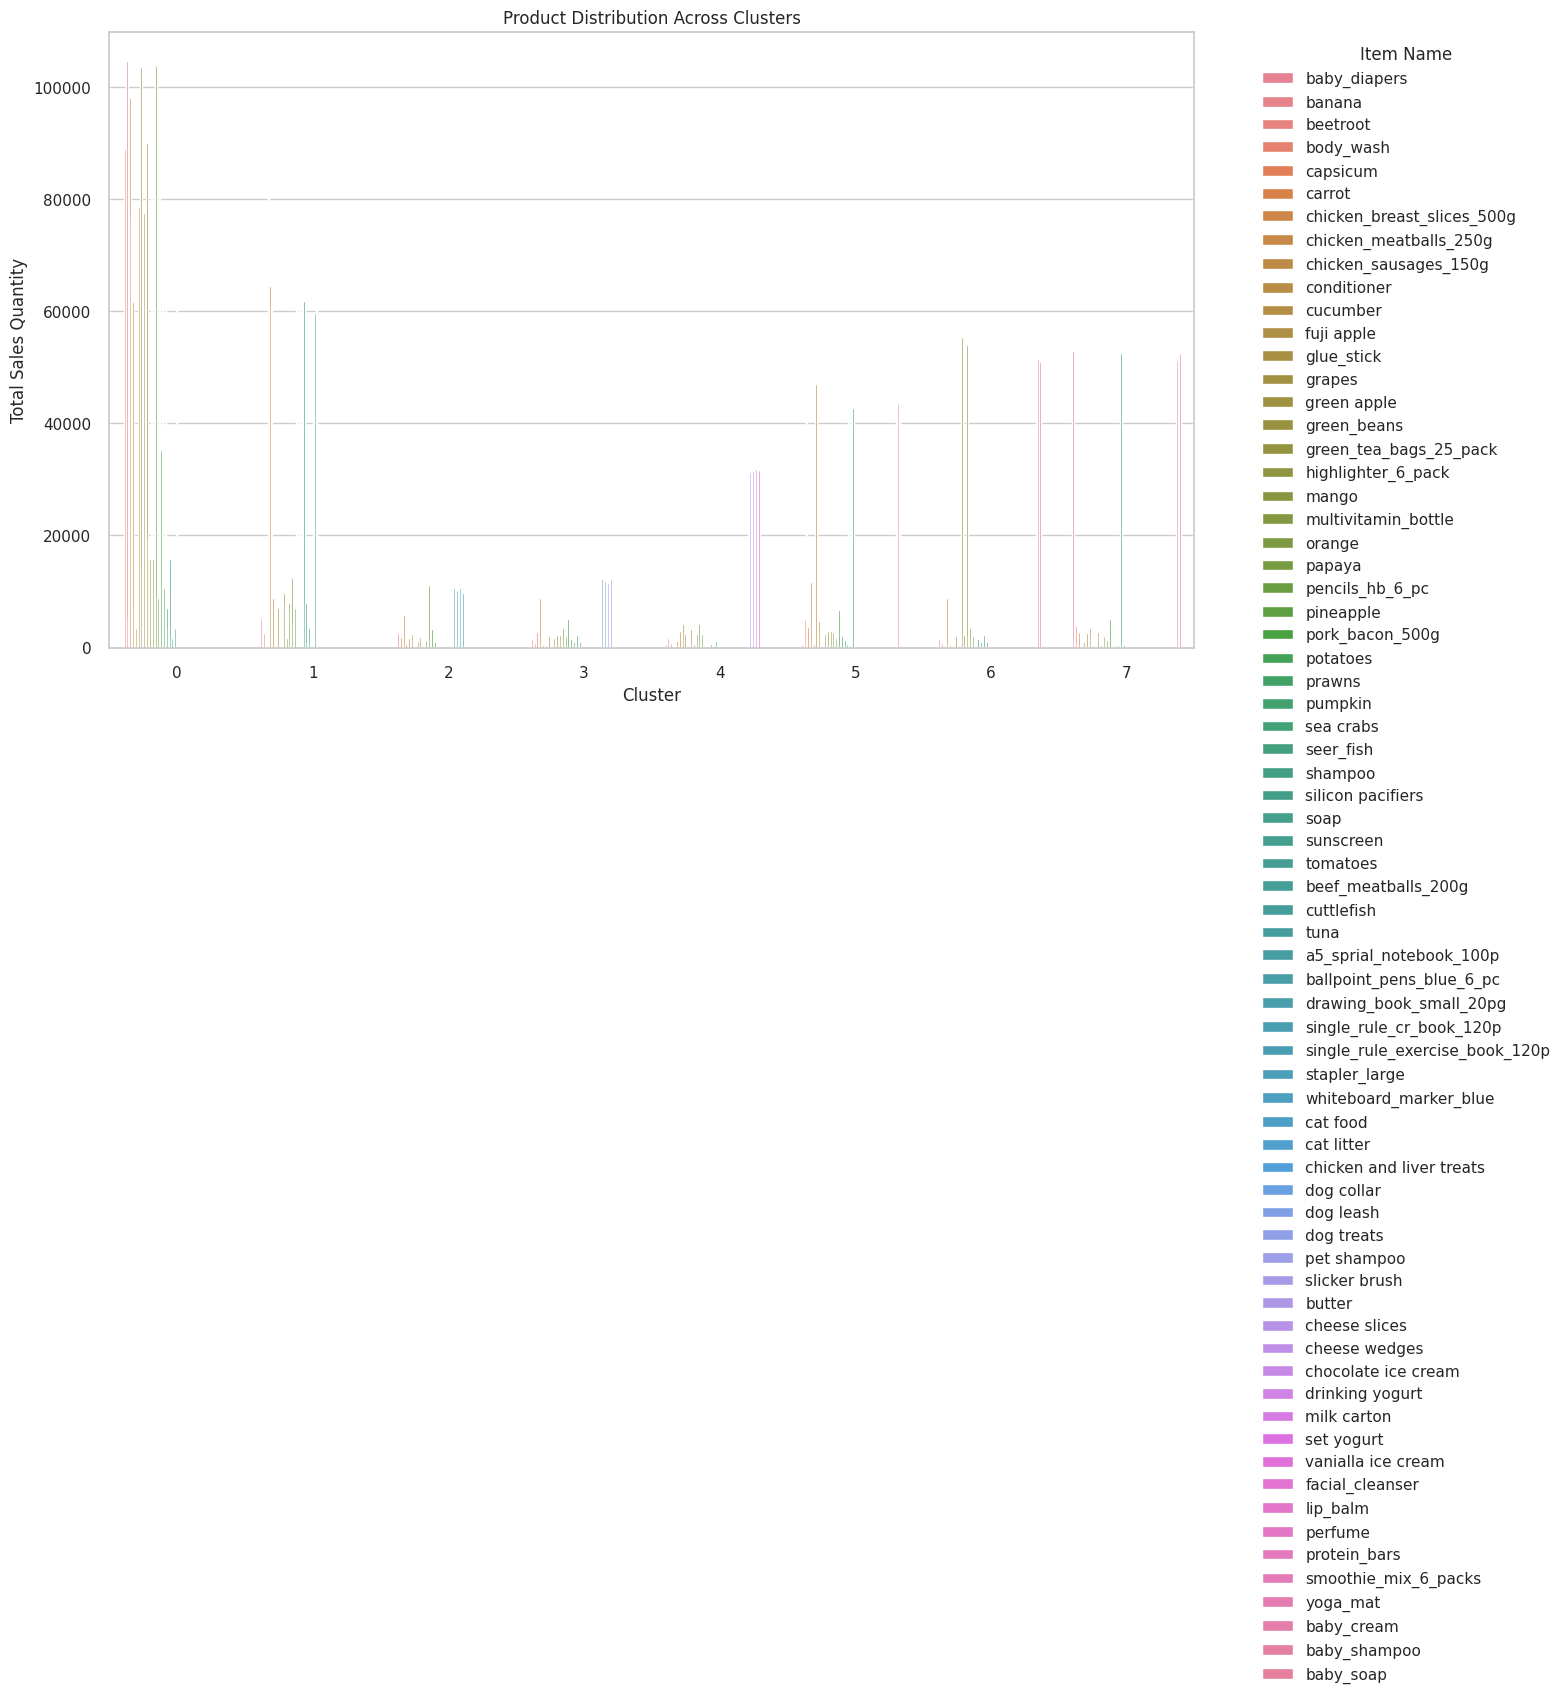

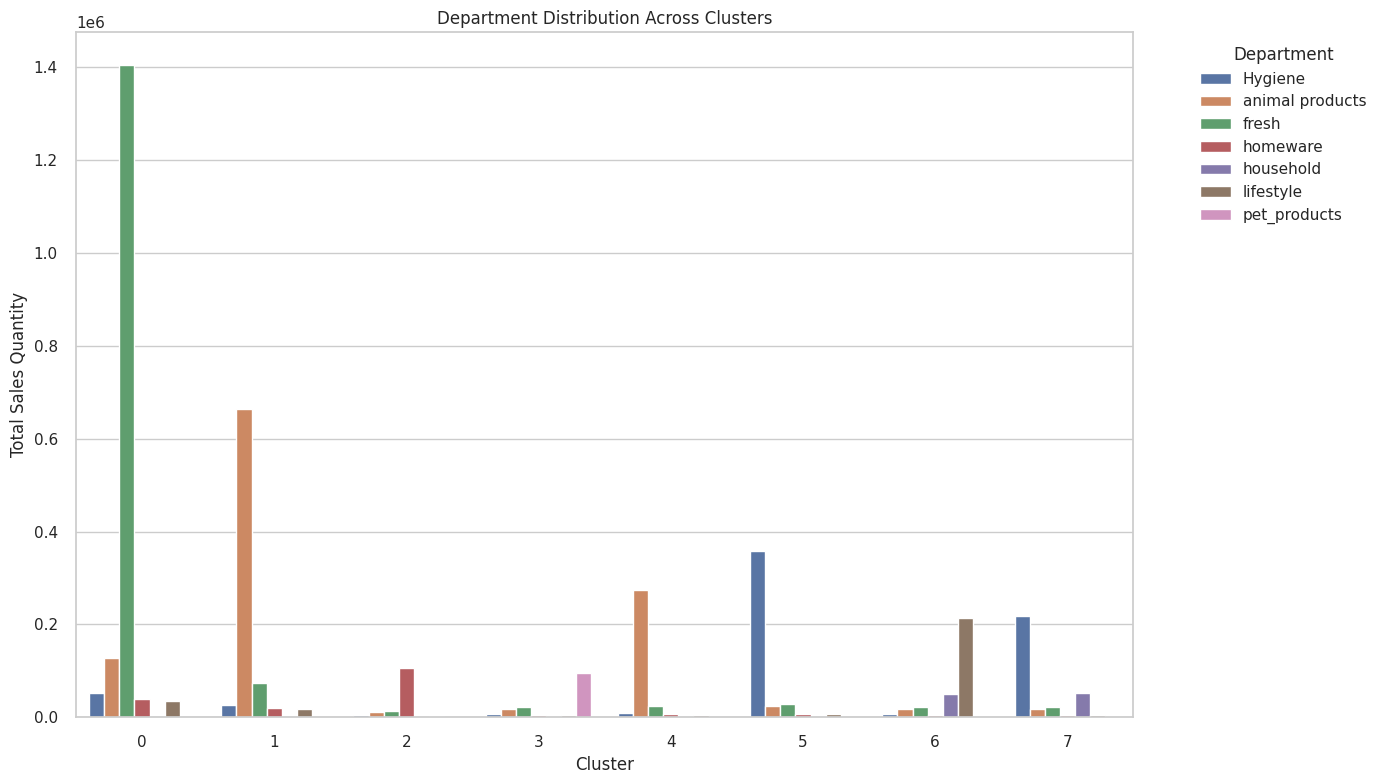

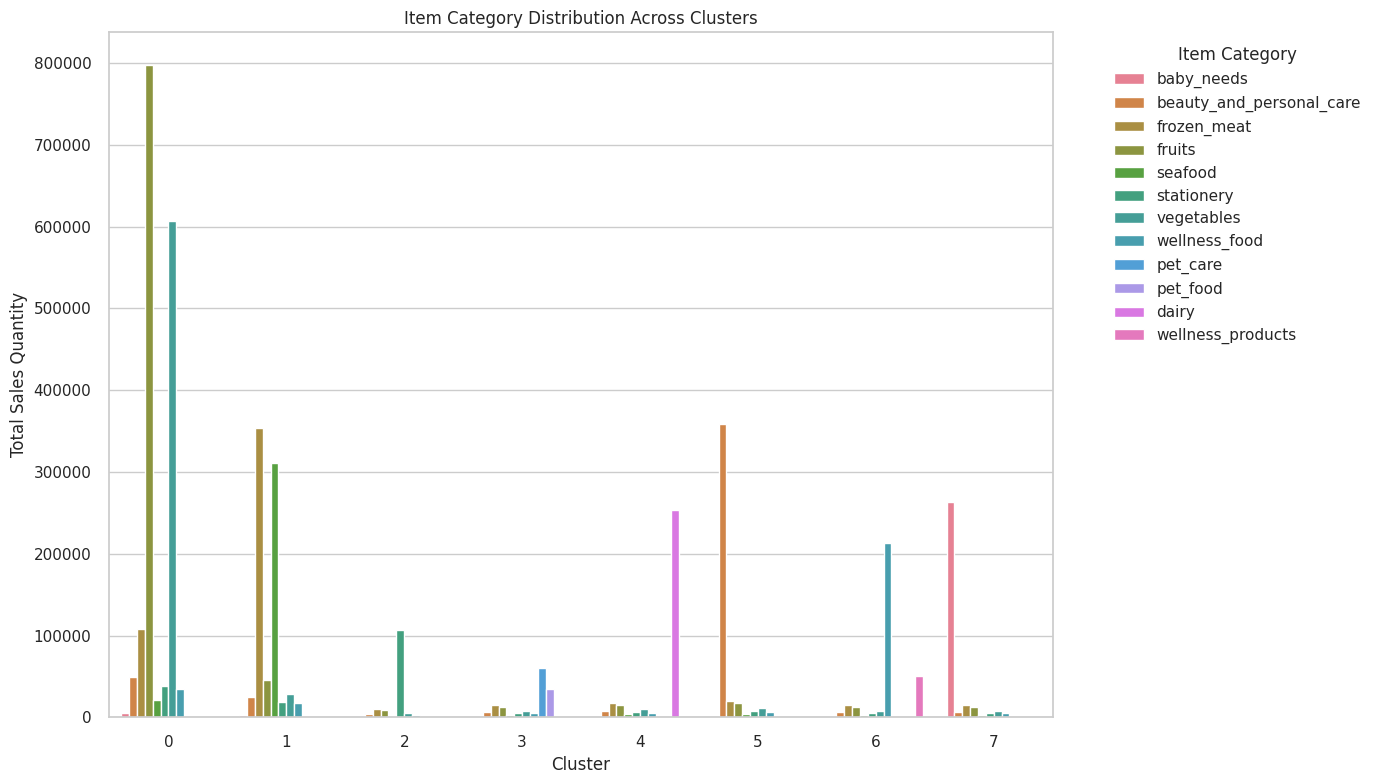

In [26]:
import pandas as pd

# Merge the cluster information with transaction data

# Aggregate data by cluster and item_name
df_item_agg = df_merged.groupby(['cluster', 'item_name']).agg({'sales_quantity': 'sum'}).reset_index()

# Aggregate data by cluster and department
df_department_agg = df_merged.groupby(['cluster', 'department']).agg({'sales_quantity': 'sum'}).reset_index()

# Aggregate data by cluster and item_category
df_category_agg = df_merged.groupby(['cluster', 'item_category']).agg({'sales_quantity': 'sum'}).reset_index()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Set the style for the plots
sns.set(style="whitegrid")

# Plot the distribution of item names across clusters
plt.figure(figsize=(14, 8))
sns.barplot(data=df_item_agg, x='cluster', y='sales_quantity', hue='item_name')
plt.title('Product Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Total Sales Quantity')
plt.legend(title='Item Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot the distribution of departments across clusters
plt.figure(figsize=(14, 8))
sns.barplot(data=df_department_agg, x='cluster', y='sales_quantity', hue='department')
plt.title('Department Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Total Sales Quantity')
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot the distribution of item categories across clusters
plt.figure(figsize=(14, 8))
sns.barplot(data=df_category_agg, x='cluster', y='sales_quantity', hue='item_category')
plt.title('Item Category Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Total Sales Quantity')
plt.legend(title='Item Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [27]:
#df_merged.to_csv('clustered_data.csv', index=False)

In [28]:
#df_merged.to_csv('/content/sample_data/clustered_data.csv', index=False)

# Chatbots


#cluster summary

In [29]:
!pip install langchain==0.1.9
!pip install langchain_openai==0.0.2
!pip install openai==1.13.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.0/817.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [30]:
# Import the OpenAI library to interact with the OpenAI API.
from openai import OpenAI

import textwrap
import requests  # used to download images
import os  # used to access filepaths
from PIL import Image  # used to print and edit images
import base64
import ipywidgets as widgets
from IPython.display import display, clear_output

In [31]:
# Set OpenAI API Key
api_key = 'sk-##'

# Initialize the OpenAI client with your API key.
client = OpenAI(api_key = api_key)

In [32]:
import pandas as pd

# Assuming 'total' is your DataFrame containing aggregated cluster data
# Aggregate by cluster
cluster_summary = total.groupby('cluster').agg({
    'customer_code': 'nunique',             # Count unique customers per cluster
    'sales_quantity': 'sum',               # Total sales quantity per cluster
    'item_category': lambda x: x.value_counts().head(3).to_dict()  # Top three item categories per cluster
}).reset_index()

# Flatten the dictionary into a readable format
cluster_summary['top_item_categories'] = cluster_summary['item_category'].apply(lambda x: ', '.join([f"{k}: {v}" for k, v in x.items()]))

# Drop the original item_category column if not needed
cluster_summary.drop(columns=['item_category'], inplace=True)

# Function to prepare data for OpenAI
def prepare_data_for_openai(cluster_summary):
    data_list = []
    for index, row in cluster_summary.iterrows():
        # Customize the prompt based on your aggregation
        prompt = f"Cluster {row['cluster']} consists of {row['customer_code']} customers. They have purchased a total of {row['sales_quantity']} items. The top three item categories they purchased are: {row['top_item_categories']}. Provide insights about this customer segment."

        # Create message structure for chatbot context
        message = {
            "role": "user",
            "content": prompt
        }
        data_list.append(message)
    return data_list

# Function to get the assistant's response using the OpenAI API
def get_assistant_response(messages):
    r = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": m["role"], "content": m["content"]} for m in messages],
        temperature=0.5,
        max_tokens=128,
        top_p=1
    )
    response = r.choices[0].message.content
    return response

# Function to format text into lines with a max of 20 words
def format_text(text, max_words_per_line=20):
    words = text.split()
    formatted_lines = []
    for i in range(0, len(words), max_words_per_line):
        line = ' '.join(words[i:i + max_words_per_line])
        formatted_lines.append(line)
    return '\n'.join(formatted_lines)

# Initialize the chat history with a system message describing the chatbot's character
messages = [
    {
        "role": "system",
        "content": "You are Marv, a retail specialized chatbot assign name for the cluster and give insights"
    }
]

# Prepare data for OpenAI
data_for_openai = prepare_data_for_openai(cluster_summary)

# Generate insights for each cluster using chatbot interaction
insights = {}
for message in data_for_openai:
    try:
        response = get_assistant_response(messages + [message])
        formatted_response = format_text(response)  # Format the response to have max 20 words per line
        insights[message['content']] = formatted_response
    except Exception as e:
        print(f"Error generating response for prompt: {message['content']}, Error: {str(e)}")

# Print or store the generated insights
for prompt, insight in insights.items():
    print(f"Marv's Insight:\n{insight}\n")


Marv's Insight:
Cluster 0 could be named "Fresh & Healthy" based on their top purchased item categories of fruits and vegetables. This
customer segment seems to prioritize fresh and nutritious food choices. The significant purchase of frozen meat also suggests that they
value convenience without compromising on quality. They may be health-conscious individuals who prefer to cook at home using fresh ingredients.
This cluster likely values variety in their diet and may be interested in exploring new recipes and flavors. Marketing healthy
and fresh food options to this segment could be an effective strategy to engage and retain these customers.

Marv's Insight:
Based on the top three item categories purchased by Cluster 1, I would suggest naming this cluster "Gourmet Delights". This
name reflects the preference of these customers for high-quality and premium food items such as frozen meat, seafood, and fruits.
Insights about this customer segment: 1. High-end Food Preferences: Cluster 1 c

In [33]:

# Function to prepare data for OpenAI
def prepare_data_for_openai(cluster_summary):
    data_list = []
    for index, row in cluster_summary.iterrows():
        # Customize the prompt based on your aggregation
        prompt = f"Cluster {row['cluster']} consists of {row['customer_code']} customers. They have purchased a total of {row['sales_quantity']} items. The top three item categories they purchased are: {row['top_item_categories']}. Provide personalized product suggestions for this customer segment."

        # Create message structure for chatbot context
        message = {
            "role": "user",
            "content": prompt
        }
        data_list.append(message)
    return data_list


# Initialize the chat history with a system message describing the chatbot's character
messages = [
    {
        "role": "system",
        "content": "You are Marv, a retail specialized chatbot. Provide personalized product suggestions for each customer segment based on their purchasing behavior."
    }
]

# Prepare data for OpenAI
data_for_openai = prepare_data_for_openai(cluster_summary)

# Generate personalized product suggestions for each cluster using chatbot interaction
suggestions = {}
for message in data_for_openai:
    try:
        response = get_assistant_response(messages + [message])
        formatted_response = format_text(response)  # Format the response to have max 20 words per line
        suggestions[message['content']] = formatted_response
    except Exception as e:
        print(f"Error generating response for prompt: {message['content']}, Error: {str(e)}")

# Print or store the generated personalized product suggestions
for prompt, suggestion in suggestions.items():
    print(f"Cluster Summary:\n{prompt}\n\nMarv's Product Suggestions:\n{suggestion}\n")


Cluster Summary:
Cluster 0 consists of 1763 customers. They have purchased a total of 1661484 items. The top three item categories they purchased are: fruits: 124558, vegetables: 97229, frozen_meat: 19393. Provide personalized product suggestions for this customer segment.

Marv's Product Suggestions:
Based on the purchasing behavior of Cluster 0 customers, here are some personalized product suggestions: 1. Fresh Fruits: - Offer
a variety of seasonal fruits such as apples, bananas, oranges, and berries. - Promote fruit baskets or bundles for a
healthy snacking option. 2. Fresh Vegetables: - Highlight a selection of organic and locally sourced vegetables like spinach, broccoli, carrots,
and bell peppers. - Create meal kits or recipe ideas that include a mix of vegetables for easy meal planning.
3. Frozen Meat: - Recommend a range of high-quality frozen meats such as chicken breasts, ground beef,

Cluster Summary:
Cluster 1 consists of 882 customers. They have purchased a total of 803977

In [34]:

# Function to prepare data for OpenAI
def prepare_data_for_openai(cluster_summary):
    data_list = []
    for index, row in cluster_summary.iterrows():
        # Customize the prompt based on your aggregation
        prompt = f"Cluster {row['cluster']} consists of {row['customer_code']} customers. They have purchased a total of {row['sales_quantity']} items. The top three item categories they purchased are: {row['top_item_categories']}. Provide personalized promotions for this customer segment."

        # Create message structure for chatbot context
        message = {
            "role": "user",
            "content": prompt
        }
        data_list.append(message)
    return data_list


# Initialize the chat history with a system message describing the chatbot's character
messages = [
    {
        "role": "system",
        "content": "You are Marv, a retail specialized chatbot. Provide personalized promotions for each customer segment based on their purchasing behavior."
    }
]

# Prepare data for OpenAI
data_for_openai = prepare_data_for_openai(cluster_summary)

# Generate personalized promotions for each cluster using chatbot interaction
promotions = {}
for message in data_for_openai:
    try:
        response = get_assistant_response(messages + [message])
        formatted_response = format_text(response)  # Format the response to have max 20 words per line
        promotions[message['content']] = formatted_response
    except Exception as e:
        print(f"Error generating response for prompt: {message['content']}, Error: {str(e)}")

# Print or store the generated personalized promotions
for prompt, promotion in promotions.items():
    print(f"Cluster Summary:\n{prompt}\n\nMarv's Promotion Suggestions:\n{promotion}\n")


Cluster Summary:
Cluster 0 consists of 1763 customers. They have purchased a total of 1661484 items. The top three item categories they purchased are: fruits: 124558, vegetables: 97229, frozen_meat: 19393. Provide personalized promotions for this customer segment.

Marv's Promotion Suggestions:
For Cluster 0 customers who have a preference for purchasing fruits, vegetables, and frozen meat, I recommend the following personalized
promotions: 1. Buy 1 Get 1 Free on selected fresh fruits to encourage more fruit purchases. 2. 10% off on
all vegetable purchases to promote healthy eating habits. 3. Special discount on bulk purchases of frozen meat products for convenient
meal planning. These promotions are tailored to cater to the specific preferences of Cluster 0 customers and encourage them to
make more purchases in their favorite categories.

Cluster Summary:
Cluster 1 consists of 882 customers. They have purchased a total of 803977 items. The top three item categories they purchased are:

## personalized recommendation

In [35]:
import pandas as pd

# Assuming 'cluster_summary' and 'insights' are already defined and populated

# Function to parse insights and create DataFrame for each customer code
def create_customer_insights(cluster_summary, insights,total):
    customer_insights = []

    for index, row in cluster_summary.iterrows():
        # Parse cluster insights
        #cluster_description = insights.get(f"Cluster {row['cluster']} consists of")

        # Aggregate insights for each customer code in the cluster
        for customer_code in total[total['cluster'] == row['cluster']]['customer_code'].unique():
            # Initialize lists to collect top items and categories
            top_items = []
            top_categories = []

            # Filter transactions for the current customer code and cluster
            customer_transactions = total[(total['customer_code'] == customer_code) & (total['cluster'] == row['cluster'])]

            # Calculate top 5 item names and counts
            top_items_data = customer_transactions['item_name'].value_counts().head(5).to_dict()
            for item_name, count in top_items_data.items():
                top_items.append({'item_name': item_name, 'count': count})

            # Calculate top 3 item categories and counts
            top_categories_data = customer_transactions['item_category'].value_counts().head(3).to_dict()
            for category, count in top_categories_data.items():
                top_categories.append({'item_category': category, 'count': count})

            # Append customer insights to the list
            customer_insights.append({
                'customer_code': customer_code,
                'top_items': top_items,
                'top_categories': top_categories,
                'cluster_label': row['cluster'],
                #'cluster_description': cluster_description
            })

    # Create DataFrame from the collected customer insights
    df_customer_insights = pd.DataFrame(customer_insights)

    return df_customer_insights

# Create DataFrame with customer insights
df_customer_insights = create_customer_insights(cluster_summary, insights,total)

# Display the resulting DataFrame
(df_customer_insights.head())


,customer_code,top_items,top_categories,cluster_label
0,customer_code_78,"[{'item_name': 'beetroot', 'count': 15}, {'ite...","[{'item_category': 'fruits', 'count': 79}, {'i...",0
1,customer_code_792,"[{'item_name': 'pineapple', 'count': 12}, {'it...","[{'item_category': 'fruits', 'count': 88}, {'i...",0
2,customer_code_4024,"[{'item_name': 'beetroot', 'count': 15}, {'ite...","[{'item_category': 'fruits', 'count': 80}, {'i...",0
3,customer_code_176,"[{'item_name': 'green_beans', 'count': 16}, {'...","[{'item_category': 'fruits', 'count': 80}, {'i...",0
4,customer_code_3254,"[{'item_name': 'grapes', 'count': 13}, {'item_...","[{'item_category': 'fruits', 'count': 78}, {'i...",0


In [36]:
# Assuming you have already defined the `get_assistant_response` function and `df_mapped` DataFrame
df_mapped=df_customer_insights.copy()
# Drop the existing `cluster_description` column if it exists
if 'cluster_description' in df_mapped.columns:
    df_mapped.drop(columns=['cluster_description'], inplace=True)

# Function to prepare data for OpenAI based on top items and categories
def prepare_data_for_openai(df):
    data_list = []
    for index, row in df.iterrows():
        # Customize the prompt based on the customer's top items and categories
        prompt = f"Customer {row['customer_code']} frequently purchases these items: {', '.join([item['item_name'] for item in row['top_items']])}. They prefer these categories: {', '.join([category['item_category'] for category in row['top_categories']])}. Suggest personalized product recommendations for them."

        # Create message structure for chatbot context
        message = {
            "role": "user",
            "content": prompt
        }
        data_list.append(message)
    return data_list

# Prepare data for OpenAI
data_for_openai = prepare_data_for_openai(df_mapped.head())
messages = [
    {
        "role": "system",
        "content": "You are Darv, a retail specialized chatbot that provide Personalized product suggestions analyzing customer purchase behavior."
    }
]

# Generate personalized product suggestions for each customer using chatbot interaction
suggestions = {}
for message in data_for_openai:
    try:
        response = get_assistant_response(messages + [message])  # Include system message and current message
        suggestions[message['content']] = response  # Use prompt as key to store suggestions
    except Exception as e:
        print(f"Error generating response for prompt: {message['content']}, Error: {str(e)}")

# Update DataFrame with personalized product suggestions
for index, row in df_mapped.iterrows():
    prompt = f"Customer {row['customer_code']} frequently purchases these items: {', '.join([item['item_name'] for item in row['top_items']])}. They prefer these categories: {', '.join([category['item_category'] for category in row['top_categories']])}. Suggest personalized product recommendations for them."
    if prompt in suggestions:
        df_mapped.at[index, 'Personalized_suggestion'] = suggestions[prompt]

# Print the updated DataFrame to verify
(df_mapped)


,customer_code,top_items,top_categories,cluster_label,Personalized_suggestion
0,customer_code_78,"[{'item_name': 'beetroot', 'count': 15}, {'ite...","[{'item_category': 'fruits', 'count': 79}, {'i...",0,Based on customer customer_code_78's frequent ...
1,customer_code_792,"[{'item_name': 'pineapple', 'count': 12}, {'it...","[{'item_category': 'fruits', 'count': 88}, {'i...",0,Based on customer customer_code_792's frequent...
2,customer_code_4024,"[{'item_name': 'beetroot', 'count': 15}, {'ite...","[{'item_category': 'fruits', 'count': 80}, {'i...",0,Based on the customer's frequent purchases of ...
3,customer_code_176,"[{'item_name': 'green_beans', 'count': 16}, {'...","[{'item_category': 'fruits', 'count': 80}, {'i...",0,Based on the customer's purchase behavior and ...
4,customer_code_3254,"[{'item_name': 'grapes', 'count': 13}, {'item_...","[{'item_category': 'fruits', 'count': 78}, {'i...",0,Based on customer_code_3254's purchase behavio...
...,...,...,...,...,...
4195,customer_code_548,"[{'item_name': 'silicon pacifiers', 'count': 2...","[{'item_category': 'baby_needs', 'count': 103}...",7,NaN
4196,customer_code_3672,"[{'item_name': 'baby_shampoo', 'count': 23}, {...","[{'item_category': 'baby_needs', 'count': 103}...",7,NaN
4197,customer_code_2028,"[{'item_name': 'silicon pacifiers', 'count': 3...","[{'item_category': 'baby_needs', 'count': 106}...",7,NaN
4198,customer_code_1163,"[{'item_name': 'silicon pacifiers', 'count': 2...","[{'item_category': 'baby_needs', 'count': 106}...",7,NaN


In [37]:
# Function to interactively ask for customer code and provide personalized product suggestions
def provide_personalized_suggestions(df):
    while True:
        customer_code = input("Please enter the customer code (or 'exit' to quit): ").strip().lower()

        if customer_code == 'exit':
            print("Exiting...")
            break

        # Find the customer in the DataFrame
        customer_row = df[df['customer_code'].str.lower() == customer_code]

        if len(customer_row) == 0:
            print(f"Customer with code '{customer_code}' not found.")
            continue

        customer_data = customer_row.iloc[0]

        # Prepare prompt based on customer's top items and categories
        prompt = f"Customer {customer_data['customer_code']} frequently purchases these items: {', '.join([item['item_name'] for item in customer_data['top_items']])}. They prefer these categories: {', '.join([category['item_category'] for category in customer_data['top_categories']])}. Suggest personalized product recommendations for them."

        try:
            # Get assistant response
            response = get_assistant_response(messages + [{"role": "user", "content": prompt}])
            print(f"Suggestions for Customer {customer_data['customer_code']}:\n{response}\n")
        except Exception as e:
            print(f"Error generating response: {str(e)}")

# Example messages to initialize the chatbot

# Execute interactive suggestions
provide_personalized_suggestions(df_mapped)


Please enter the customer code (or 'exit' to quit): customer_code_1
Suggestions for Customer customer_code_1:
Based on the customer's purchase behavior and preferences, here are some personalized product recommendations for customer_code_1:

1. Blueberries
2. Spinach
3. Mango
4. Sweet potatoes
5. Broccoli
6. Strawberries
7. Cauliflower
8. Frozen chicken breasts
9. Frozen salmon fillets
10. Frozen shrimp

These suggestions align with the customer's preference for fruits, vegetables, and frozen meat products. I hope these recommendations are helpful for customer_code_1!

Please enter the customer code (or 'exit' to quit): exit
Exiting...


## Personalized promotions.

In [38]:

# Merge datasets on customer_code
df_promotion = pd.merge(df_mapped, customer_metrics, on='customer_code', how='left')

# Function to prepare data for OpenAI
def prepare_data_for_openai(customer_row):
    customer_code = customer_row['customer_code']
    top_items = customer_row['top_items']
    top_categories = customer_row['top_categories']
    recency = customer_row['recency']
    tenure = customer_row['tenure']
    frequency = customer_row['frequency']
    total_sales = customer_row['total_sales']
    unique_items_purchased = customer_row['unique_items_purchased']
    most_frequent_item = customer_row['most_frequent_item']
    most_frequent_item_quantity = customer_row['most_frequent_item_quantity']
    average_quantity_per_item = customer_row['average_quantity_per_item']

    # Create a prompt with detailed customer data
    top_items_str = ', '.join([f"{item['item_name']} (count: {item['count']})" for item in top_items])
    top_categories_str = ', '.join([f"{cat['item_category']} (count: {cat['count']})" for cat in top_categories])

    prompt = (
        f"Customer Code: {customer_code}\n"
        f"Recency: {recency} days\n"
        f"Tenure: {tenure} days\n"
        f"Frequency: {frequency} purchases\n"
        f"Total Sales: ${total_sales}\n"
        f"Unique Items Purchased: {unique_items_purchased}\n"
        f"Most Frequent Item: {most_frequent_item} (Quantity: {most_frequent_item_quantity})\n"
        f"Average Quantity per Item: {average_quantity_per_item:.2f}\n"
        f"Top Items: {top_items_str}\n"
        f"Top Categories: {top_categories_str}\n\n"
        f"Based on the above information, generate personalized promotions and suggestions for this customer."
    )

    return prompt

messages = [
    {
        "role": "system",
        "content": "You are a marketing specialist providing personalized promotions for retail customers."
    }
]


# Function to interactively ask for customer code and provide personalized promotions
def provide_personalized_promotions(df_combined):
    while True:
        customer_code = input("Please enter the customer code (or 'exit' to quit): ").strip().lower()

        if customer_code == 'exit':
            print("Exiting...")
            break

        # Find the customer in the DataFrame
        customer_row = df_combined[df_combined['customer_code'].str.lower() == customer_code]

        if len(customer_row) == 0:
            print(f"Customer with code '{customer_code}' not found.")
            continue

        customer_data = customer_row.iloc[0]

        # Prepare data for OpenAI
        prompt = prepare_data_for_openai(customer_data)

        # Create the message for OpenAI
        message = {"role": "user", "content": prompt}

        # Get personalized promotion from OpenAI
        promotion_message = get_assistant_response(messages + [message])
        print(f"\nPersonalized Promotions for {customer_code}:\n{promotion_message}\n")

# Execute interactive promotions
provide_personalized_promotions(df_promotion)


Please enter the customer code (or 'exit' to quit): customer_code_1

Personalized Promotions for customer_code_1:
Given the customer's high frequency of purchases and total sales, it's clear they are a loyal and valuable customer. To further incentivize their continued patronage, here are some personalized promotions and suggestions:

1. Loyalty Reward: Offer a special discount or bonus points for their next purchase to show appreciation for their frequent transactions.

2. Bundle Deal: Create a bundle offer including some of their favorite items like beetroot, grapes, fuji apple, papaya, and green beans at a discounted price to encourage larger purchases.

3. Exclusive Category Discount: Provide a discount on products from the top categories they purchase from, such as fruits,

Please enter the customer code (or 'exit' to quit): exit
Exiting...
